In [2]:
from golden import *
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Iniciando o client para acessar o BQ
client_bq = config_client('prod')

DefaultCredentialsError: Your default credentials were not found. To set up Application Default Credentials, see https://cloud.google.com/docs/authentication/external/set-up-adc for more information.

In [3]:
# Verificando se o client está conectado
check_client_connection(client_bq)

True

In [26]:
# Declarando a query que deseja utilizar
query_bq = """
with
  assinatura_contrato as (
    select
      concat('nf-',usp.id) as id
      , parse_date('%d/%m/%Y', substr(usp.digital_signature, 23, 10)) as data_assinatura_contrato
      , b.dt_microchipagem
    from `petlove-dataeng-prod-01.curated_health.health_user_pet` usp
    left join `petlove-dataeng-prod-01.op_health.beneficiarios` b
      on concat('nf-',usp.id) = b.id_pet_bu
    where 1=1
      and digital_signature is not null
      and usp.refdate <= current_date()
      and substr(usp.digital_signature, 23, 10) <> ''
      and b.dt_microchipagem is not null
  ),
  setup as (
    select
      id as id_pet_bu
      , data_assinatura_contrato
      , dt_microchipagem
      , case
          when data_assinatura_contrato > dt_microchipagem then data_assinatura_contrato
          when dt_microchipagem >= data_assinatura_contrato then dt_microchipagem
          else dt_microchipagem
        end as data_setup
    from assinatura_contrato
  ),
  vacina as (
    select distinct
      id_pet_bu
      , max(data_origem_date) as data_vacina
    from `petlove-dataeng-prod-01.op_health.custos_medicos`
    where 1=1
      and status = 'Ativo'
      and sistema_origem_custo = 'ERP Nofaro'
      and upper(nome_procedimento) like '%VACINA%'
      and upper(nome_procedimento) not like '%CONSULTA%'
    group by 1
  ),
  compra_add as (
    select
      id_pet_bu
      , max(dt_pagamento) as data_pagamento
    from `petlove-dataeng-prod-01.op_health.faturamento_pet_nofaro`
    where 1=1
      and vlr_carencia <> 0
    group by 1
  ),
  clinico_geral as (
    select
      id_pet_bu
      , max(data_origem_date) as data_atend_clin_geral
    from `petlove-dataeng-prod-01.op_health.custos_medicos`
    where 1=1
      and status = 'Ativo'
      and sistema_origem_custo = 'ERP Nofaro'
      and (upper(nome_procedimento) like '%CONSULTA%' and upper(nome_procedimento) like '%GERAL%' and upper(nome_procedimento) not like '%VACINA%')
    group by id_pet_bu
  ),
  pedido_ecom as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when max(fpf1.chv_data_emissao_nota_fiscal) > max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf1.chv_data_emissao_nota_fiscal)
          when max(fpf1.chv_data_emissao_nota_fiscal) < max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf2.chv_data_emissao_nota_fiscal)
          when max(fpf1.chv_data_emissao_nota_fiscal) = max(fpf2.chv_data_emissao_nota_fiscal) then max(fpf1.chv_data_emissao_nota_fiscal)
      end as dt_pedido_ecom
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
      on dc1.chv_cliente = fpf1.chv_cliente
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
      on dc2.chv_cliente = fpf2.chv_cliente
    group by 1,2
  ),
  primeiro_pedido_ecom as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(fpf1.chv_data_emissao_nota_fiscal) < min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf1.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) > min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf2.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) = min(fpf2.chv_data_emissao_nota_fiscal) then date(min(fpf1.chv_data_emissao_nota_fiscal))
          when min(fpf1.chv_data_emissao_nota_fiscal) is null then date(min(fpf2.chv_data_emissao_nota_fiscal))
          when min(fpf2.chv_data_emissao_nota_fiscal) is null then date(min(fpf1.chv_data_emissao_nota_fiscal))
      end as dt_primeiro_pedido_ecom
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente`  dc2
      on dc2.email_aberto = lower(trim(b.email))
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
      on dc1.chv_cliente = fpf1.chv_cliente
    left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
      on dc2.chv_cliente = fpf2.chv_cliente
    group by 1,2
  ),
  primeiro_servico_dh as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(dc1.dt_primeiro_servico) < min(dc2.dt_primeiro_servico) then date(min(dc1.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) > min(dc2.dt_primeiro_servico) then date(min(dc2.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) = min(dc2.dt_primeiro_servico) then date(min(dc1.dt_primeiro_servico))
          when min(dc1.dt_primeiro_servico) is null then date(min(dc2.dt_primeiro_servico))
          when min(dc2.dt_primeiro_servico) is null then date(min(dc1.dt_primeiro_servico))
      end as dt_primeiro_servico_dh
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    group by 1,2  
  ),
  cluster_tutores as (
    select
      id_tutor
      , cluster_name
      , rank() over(partition by id_tutor order by refdate desc) as rk
    from `op_health.tutores_clusters`
    order by 2 asc
  ),
  clube as (
    select
      b.id_pet_bu
      , b.nome_pet
      , case
          when min(dc1.dt_entrada_clube) < min(dc2.dt_entrada_clube) then date(min(dc1.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) > min(dc2.dt_entrada_clube) then date(min(dc2.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) = min(dc2.dt_entrada_clube) then date(min(dc1.dt_entrada_clube))
          when min(dc1.dt_entrada_clube) is null then date(min(dc2.dt_entrada_clube))
          when min(dc2.dt_entrada_clube) is null then date(min(dc1.dt_entrada_clube))
      end as dt_entrada_clube
    from `petlove-dataeng-prod-01.op_health.beneficiarios` b
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
      on dc1.cpf_aberto = b.documento
    left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
    group by 1,2    
  ),
  ecom_detalhado as (
    with uniao_chaves as (
      select
        b.id_pet_bu
        , b.nome_pet
        , mc1.setor
        , mc1.familia
        , mc1.subfamilia
        , mc1.marca
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
        on dc1.cpf_aberto = b.documento
      left join `petlove-dataeng-prod-01.dw_corporativo.dts_margem_conciliacao` mc1
        on dc1.chv_cliente = mc1.chv_cliente
      where 1=1
        and mc1.setor in ('Alimentos','Medicina e Bem Estar','Brinquedos','Acessórios','Higiene e Beleza')
      union all
      select
        b.id_pet_bu
        , b.nome_pet
        , mc2.setor
        , mc2.familia
        , mc2.subfamilia
        , mc2.marca
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
      left join `petlove-dataeng-prod-01.dw_corporativo.dts_margem_conciliacao` mc2
        on dc2.chv_cliente = mc2.chv_cliente
      where 1=1
        and mc2.setor in ('Alimentos','Medicina e Bem Estar','Brinquedos','Acessórios','Higiene e Beleza')
    )
    select
      id_pet_bu
      , nome_pet
      , string_agg(distinct setor, " | " order by setor asc) as mix_setores
      , string_agg(distinct familia, " | " order by familia asc) as mix_familias
      , string_agg(distinct subfamilia, " | " order by subfamilia asc) as mix_subfamilias
      , string_agg(distinct marca, " | " order by marca asc) as mix_marcas
    from uniao_chaves
    group by 1,2
  ),
  frequencia_compra as (
    with uniao_chaves as (
      select
        b.id_pet_bu
        , b.nome_pet
        , fpf1.chv_data_emissao_nota_fiscal as primeiro_pedido
        , fpf1.chv_data_emissao_nota_fiscal as ultimo_pedido
        , fpf1.pedido_beagle
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc1
        on dc1.cpf_aberto = b.documento
      left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf1
        on dc1.chv_cliente = fpf1.chv_cliente
      union all
      select
        b.id_pet_bu
        , b.nome_pet
        , fpf2.chv_data_emissao_nota_fiscal as primeiro_pedido
        , fpf2.chv_data_emissao_nota_fiscal as ultimo_pedido
        , fpf2.pedido_beagle
      from `petlove-dataeng-prod-01.op_health.beneficiarios` b
      left join `petlove-dataeng-prod-01.dw_corporativo.dim_cliente` dc2
        on dc2.email_aberto = lower(trim(b.email))
      left join `petlove-dataeng-prod-01.dw_corporativo.ft_pedido_faturado` fpf2
        on dc2.chv_cliente = fpf2.chv_cliente
    )
    select
      id_pet_bu
      , nome_pet
      , min(primeiro_pedido) primeiro_pedido
      , max(ultimo_pedido) ultimo_pedido
      , count(distinct pedido_beagle) as pedidos
      , date_diff(max(ultimo_pedido),min(primeiro_pedido), day) as dias
      , case
          when count(distinct pedido_beagle) = 0 then 0
          else round(date_diff(max(ultimo_pedido),min(primeiro_pedido), day)/count(distinct pedido_beagle),0)
      end as frequencia
    from uniao_chaves
    -- where id_pet_bu = 'nf-181328'
    group by 1,2  
  ),
  beneficiarios as (
    select
      id_tutor,
      (case when REGEXP_EXTRACT(lower(email), r'@(.+)') in ('gmail.com', 'hotmail.com', 'yahoo.com.br','outlook.com', 'icloud.com', 'uol.com.br', 'live.com', 'terra.com.br', 'yahoo.com')
            then REGEXP_EXTRACT(lower(email), r'@(.+)')
            else 'outros.com'
            end) as email_dominio,
      idade_pet_venda,
      idade_pet_anos,
      cast(id_pet as int64) as id_pet,
      nome_pet,
      dt_inclusao_pet,
      date_diff(coalesce(dt_desligamento, current_date), dt_inclusao_pet, day) as tempo_ativo,
      fl_ativo,
      especie,
      status_microchip,
      coalesce(dt_desligamento, current_date) as dt_desligamento_nn,
      case
        when lower(nome_plano_dts_pet) like '%leve%' then 'leve'
        when lower(nome_plano_dts_pet) like '%tranquilo%' then 'tranquilo'
        when lower(nome_plano_dts_pet) like '%ideal%' then 'ideal'
        when lower(nome_plano_dts_pet) like '%completo%' then 'completo'
        when lower(nome_plano_dts_pet) like '%essencial%' then 'essencial'
        else 'outros' 
      end as plano,
      fl_inside_sales
    from `op_health.beneficiarios`
    where 1=1
       and (date_trunc(dt_inclusao_pet, month) <= '2024-07-01') --net_adds
       and (date_trunc(dt_desligamento, month) is null or date_trunc(dt_desligamento, month) > '2024-07-01') --net_adds
       and fl_contrato_migrado = 0
       and fl_pet_sem_inclusao = 0
       --and dt_inclusao_pet <= current_date-180 
       --and fl_colaborador = 0
       --and dt_inclusao_pet >= '2023-01-01'
       --and idade_pet_venda is not null 
       --and idade_pet_venda >= 0
       --and empresa = 'Nofaro'
       --and especie is not null
       --and (motivo_desligamento not in ('Óbito', 'defaulting_wating', 'defaulting_failed', 'death', 'defaulting', 'Morte de pet', 'Inadimplência', 'Inadimplência: aguardando', 'Inadimplência: falha no p') or motivo_desligamento is null)
  ),
  simultaneos as (
    select
      b1.id_tutor,
      b1.id_pet,
      count(distinct b2.id_pet) as pets_simultaneos_ativos
    from beneficiarios b1
    left join beneficiarios b2
      on b1.id_tutor = b2.id_tutor
      and ((b1.dt_desligamento_nn > b2.dt_inclusao_pet and b1.dt_desligamento_nn <= b2.dt_desligamento_nn)
      or (b1.dt_inclusao_pet > b2.dt_inclusao_pet and b1.dt_inclusao_pet <= b2.dt_desligamento_nn))
    group by 1, 2
  ),
  juncao as (
    select
      b.id_tutor,
      b.email_dominio,
      b.idade_pet_venda,
      b.idade_pet_anos,
      b.id_pet,
      b.nome_pet,
      b.dt_inclusao_pet,
      case when b.tempo_ativo < 0
           then 0
           else b.tempo_ativo end as tempo_ativo,
      cast(b.fl_ativo as bool) as fl_ativo,
      b.plano,
      b.especie,
      b.status_microchip,
      b.fl_inside_sales,
      s.pets_simultaneos_ativos,
      st.data_setup as dt_setup,
      case when st.id_pet_bu is null
           then false
           else true end as tem_setup,
      v.data_vacina as dt_max_vacina,
      case when v.id_pet_bu is null
           then false
           else true end as tem_vacina,
      ca.data_pagamento as dt_max_compra_add,
      case when ca.id_pet_bu is null
           then false
          else true end as tem_adicional,
      cg.data_atend_clin_geral as dt_max_clin_geral,
      case when cg.id_pet_bu is null
           then false
           else true end as tem_atendimento,
      pe.dt_pedido_ecom as dt_max_pedido_ecom,
      case when pe.id_pet_bu is null
           then false
           else true end as tem_ecom,
      ppe.dt_primeiro_pedido_ecom as dt_primeiro_pedido_ecom,
      psdh.dt_primeiro_servico_dh as dt_primeiro_servico_dh,
      c.dt_entrada_clube,
      ct.cluster_name,
      case when ppe.dt_primeiro_pedido_ecom < b.dt_inclusao_pet
           then 'cliente ecom antes do plano'
           when b.dt_inclusao_pet < ppe.dt_primeiro_pedido_ecom
           then 'cliente ecom depois do plano'
           when ppe.dt_primeiro_pedido_ecom is null
           then 'não é cliente ecom'
           when ppe.dt_primeiro_pedido_ecom = b.dt_inclusao_pet
           then 'adesão de plano e ecom na mesma data'
           else 'verificar' end as fl_cross_ecom,
      case when psdh.dt_primeiro_servico_dh < b.dt_inclusao_pet
           then 'cliente dh antes do plano'
           when b.dt_inclusao_pet < psdh.dt_primeiro_servico_dh
           then 'cliente dh depois do plano'
           when psdh.dt_primeiro_servico_dh is null
           then 'não é cliente dh'
           when psdh.dt_primeiro_servico_dh = b.dt_inclusao_pet
           then 'adesão de plano e dh na mesma data'
           else 'verificar' end as fl_cross_dh,
      case when c.dt_entrada_clube is not null
           then 1
           else 0 end as fl_clube,
      ed.mix_setores,
      ed.mix_familias,
      ed.mix_subfamilias,
      ed.mix_marcas,
      fc.frequencia as frequencia_compra_ecom
    from beneficiarios b
    join simultaneos s
      on b.id_tutor = s.id_tutor 
      and b.id_pet = s.id_pet
      and s.pets_simultaneos_ativos > 0
    left join setup st
      on concat('nf-',b.id_pet) = st.id_pet_bu
    left join vacina v
      on concat('nf-',b.id_pet) = v.id_pet_bu
    left join compra_add ca
      on concat('nf-',b.id_pet) = ca.id_pet_bu
    left join clinico_geral cg
      on concat('nf-',b.id_pet) = cg.id_pet_bu
    left join pedido_ecom pe
      on concat('nf-',b.id_pet) = pe.id_pet_bu
      and pe.dt_pedido_ecom is not null
    left join primeiro_pedido_ecom ppe
      on concat('nf-',b.id_pet) = ppe.id_pet_bu
      and ppe.dt_primeiro_pedido_ecom is not null
    left join cluster_tutores ct
      on b.id_tutor = ct.id_tutor
      and ct.rk = 1
    left join primeiro_servico_dh psdh
      on concat('nf-',b.id_pet) = psdh.id_pet_bu
      and psdh.dt_primeiro_servico_dh is not null
    left join clube c
      on concat('nf-',b.id_pet) = c.id_pet_bu
      and c.dt_entrada_clube is not null
    left join ecom_detalhado ed
      on concat('nf-',b.id_pet) = ed.id_pet_bu
    left join frequencia_compra fc
      on concat('nf-',b.id_pet) = fc.id_pet_bu
  where 1=1
    --and b.plano not in ('outros')
  ),
  base_final_v0 as (
    select
      * 
    from juncao
    unpivot(
      data for habito in (dt_inclusao_pet as 'inclusao', dt_setup as 'setup', dt_max_vacina as 'vacina', dt_max_compra_add as 'add', dt_max_clin_geral as 'clinico', dt_max_pedido_ecom as 'ecom')
    )
  ),
  base_final_v1 as (
  select
    f.id_tutor
    , f.email_dominio
    , f.idade_pet_venda
    , f.idade_pet_anos
    , f.id_pet
    , b.dt_inclusao_pet
    , coalesce(b.dt_desligamento, current_date()) as dt_desligamento
    , f.nome_pet
    , f.tempo_ativo
    , f.plano
    , f.especie
    , initcap(trim(b.cidade_tutor)) cidade
    , initcap(trim(b.tutor_bairro)) bairro
    , f.status_microchip
    , cast(f.pets_simultaneos_ativos as float64) as pets_simultaneos_ativos
    , max(f.tem_setup) setup
    , max(f.tem_vacina) vacina
    , max(f.tem_adicional) add
    , max(f.tem_atendimento) clinico
    , max(f.tem_ecom) ecom
    , string_agg(f.habito order by data) as mix_procedimentos_data
    , string_agg(f.habito order by f.habito) as mix_procedimentos_alf
    , split(string_agg(f.habito order by data desc), ',')[offset(0)] ultimo_evento
    , max(f.data) as data_ultimo_evento
    , f.dt_primeiro_pedido_ecom
    , f.dt_primeiro_servico_dh
    , f.dt_entrada_clube
    , f.mix_setores
    , f.mix_familias
    , f.mix_subfamilias
    , f.mix_marcas
    , f.frequencia_compra_ecom
    , f.cluster_name
    , case when f.fl_ativo = true then false
          when f.fl_ativo = false then true
          end as fl_churn
    , f.fl_inside_sales
    , f.fl_clube
    , f.fl_cross_ecom
    , f.fl_cross_dh
    , case when date_diff(coalesce(b.dt_desligamento, current_date()),max(f.data), day) < 0
          then 0
          else date_diff(coalesce(b.dt_desligamento, current_date()),max(f.data), day) end as survival_in_days
  from base_final_v0 f
  left join `petlove-dataeng-prod-01.op_health.beneficiarios` b
    on concat('nf-',f.id_pet) = b.id_pet_bu
  group by
    f.id_tutor
    , f.email_dominio
    , f.idade_pet_venda
    , f.idade_pet_anos
    , f.id_pet
    , b.dt_inclusao_pet
    , b.dt_desligamento
    , f.nome_pet
    , f.tempo_ativo
    , f.plano
    , f.especie
    , b.cidade_tutor
    , b.tutor_bairro
    , f.status_microchip
    , f.pets_simultaneos_ativos
    , f.dt_primeiro_pedido_ecom
    , f.dt_primeiro_servico_dh
    , f.dt_entrada_clube
    , f.mix_setores
    , f.mix_familias
    , f.mix_subfamilias
    , f.mix_marcas
    , f.frequencia_compra_ecom
    , f.cluster_name
    , f.fl_ativo
    , f.fl_inside_sales
    , f.fl_cross_ecom
    , f.fl_clube
    , f.fl_cross_dh
)
select
  *
from base_final_v1
"""

In [27]:
# Verificando o consumo da query no BQ
query_bytes(query_bq, client_bq)

Quer matar o Cesar????


'8.99 GB'

In [28]:
# Rodando a query e salvando em um dataset
df = run_query(query_bq, client_bq)

Quer matar o Cesar????
Esta consulta processará 8.99 GB.


Deseja executar a consulta? (Y/N) Y


Iniciando query
Iniciando a consulta: 2024-07-15 14:50:30
Consulta concluída: 2024-07-15 14:54:26
Duração da consulta: 0:03:55.667710


In [29]:
# Visualizando o dataframe
df

,id_tutor,email_dominio,idade_pet_venda,idade_pet_anos,id_pet,dt_inclusao_pet,dt_desligamento,nome_pet,tempo_ativo,plano,...,mix_subfamilias,mix_marcas,frequencia_compra_ecom,cluster_name,fl_churn,fl_inside_sales,fl_clube,fl_cross_ecom,fl_cross_dh,survival_in_days
0,94274.0,terra.com.br,6.0,10.0,119409,2020-06-15,2024-07-15,Adele,1491,outros,...,Caixas e Bolsas de Transporte | Ração Medicame...,Fábrica Pet | Royal Canin,790.0,PetPremium,False,0,0,cliente ecom antes do plano,não é cliente dh,4
1,120838.0,outros.com,0.0,7.0,147497,2017-12-04,2024-07-15,Moana,2415,outros,...,None,None,0.0,PetPremium,False,0,0,não é cliente ecom,não é cliente dh,25
2,349102.0,gmail.com,1.0,2.0,485739,2024-01-08,2024-07-15,Bebê Princesa,189,leve,...,Areias e Granulados | Ração Seca | Ração Úmida,Pipicat | Sheba | Whiskas,51.0,PetSoft,False,0,0,cliente ecom antes do plano,não é cliente dh,28
3,92333.0,hotmail.com,3.0,6.0,117706,2021-05-10,2024-07-15,Julie,1162,ideal,...,Acessórios para Alimentação | Anti-inflamatóri...,Advantage Max3 | Agener União | Alklin Pet | A...,98.0,PetPremium,False,0,0,cliente ecom antes do plano,não é cliente dh,33
4,116686.0,gmail.com,2.0,5.0,142885,2021-10-28,2024-07-15,Fred Mercury Araújo De Almeida,991,outros,...,Coletor de Fezes | Cordas e Dental Bone | Raçã...,Buddy Toys | Pipicão | PremieR,0.0,PetWell,False,0,0,cliente ecom depois do plano,não é cliente dh,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502723,128377.0,hotmail.com,5.0,7.0,156249,2023-02-15,2024-07-15,Tina Turner,516,tranquilo,...,Areias e Granulados | Banheiros e Sanitários |...,Bellokão | CarePet | GoldeN | Keldog | Meau | ...,198.0,PetSoft,False,0,0,cliente ecom antes do plano,não é cliente dh,6
502724,23172.0,gmail.com,7.0,9.0,31197,2021-11-23,2024-07-15,Mike,965,ideal,...,Acessórios para Alimentação | Anti-inflamatóri...,Agener União | Apoquel | Avert | Cepav | Chale...,105.0,PetSoft,False,0,0,cliente ecom antes do plano,não é cliente dh,28
502725,152365.0,gmail.com,3.0,4.0,188531,2023-03-24,2024-07-15,Salem,479,tranquilo,...,Vermífugos,Milbemax,0.0,PetPremium,False,0,0,cliente ecom antes do plano,não é cliente dh,24
502726,179275.0,hotmail.com,3.0,4.0,226181,2023-05-18,2024-07-15,George,424,essencial,...,Acessórios para Alimentação | Acessórios para ...,Agener União | Bichinho Chic | Chalesco | Dr. ...,39.0,PetWell,False,0,0,cliente ecom antes do plano,não é cliente dh,1


In [8]:
# Extraindo os dados para um xlsx
#save_to_csv(df, path = '/mnt/c/Users/anderson.paiva/Downloads', file_name = 'base_sobrevivencia_20240715')

'Arquivo base_sobrevivencia_20240715.csv salvo com sucesso em /mnt/c/Users/anderson.paiva/Downloads/base_sobrevivencia_20240715.csv!!'

In [34]:
repres_planos = df.groupby('plano').agg({'id_pet': 'count'})  # Agregar múltiplas funções
repres_planos.sum()

id_pet    502728
dtype: int64

In [110]:
df['dt_inclusao_pet'] = pd.to_datetime(df['dt_inclusao_pet'])
data_limite = datetime.now() - timedelta(days=180)
df_maior_6m = df[df['dt_inclusao_pet'] < data_limite]

In [111]:
repres_planos = df_maior_6m.groupby('plano').agg({'id_pet': 'count'})  # Agregar múltiplas funções
repres_planos.sum()

id_pet    267746
dtype: int64

In [112]:
df_idade = df[(df['idade_pet_anos'].notnull()) & (df['idade_pet_anos'] > 0)]

In [114]:
# Calculando os limites do IQR
Q1 = df_idade['idade_pet_anos'].quantile(0.25)
Q3 = df_idade['idade_pet_anos'].quantile(0.75)
IQR = Q3 - Q1

# Definindo os limites
##limite_inferior = Q1 - 1.5 * IQR
limite_inferior = 0
limite_superior = Q3 + 1.5 * IQR

print(f'Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}')

# Filtrando outliers
df_idade_so = df_idade[(df_idade['idade_pet_anos'] >= limite_inferior) & (df_idade['idade_pet_anos'] <= limite_superior)]

Limite Inferior: 0, Limite Superior: 17.0


In [115]:
df_idade_so_perc = df_idade_so['idade_pet_anos'].value_counts(normalize=True) * 100
print(df_idade_so_perc)

idade_pet_anos
1.0     15.185459
3.0     12.381138
2.0     12.304648
4.0     10.755553
5.0      8.329730
6.0      7.855678
7.0      6.778077
8.0      6.178247
9.0      5.168534
10.0     4.538712
11.0     3.502262
12.0     2.725273
13.0     1.873422
14.0     1.237091
15.0     0.674227
16.0     0.350598
17.0     0.161350
Name: proportion, dtype: float64


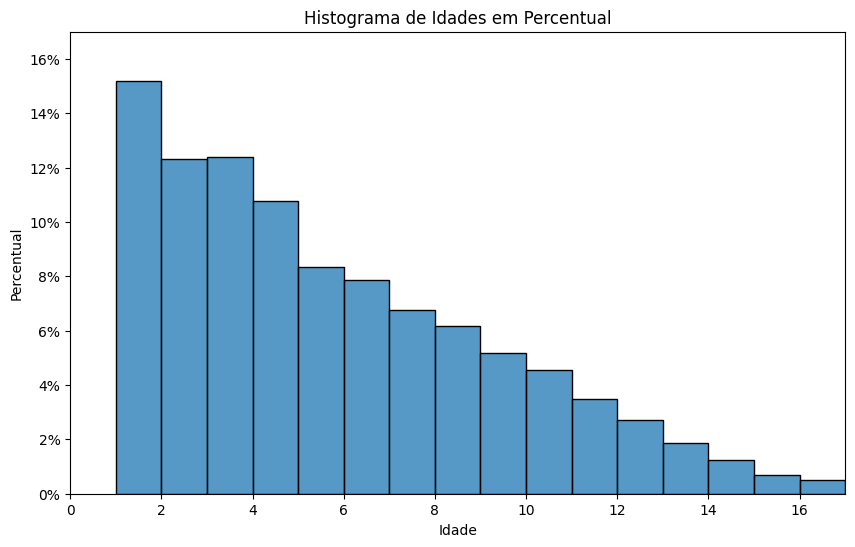

In [151]:
plt.figure(figsize=(10, 6))
##plt.hist(df_idade_so['idade_pet_anos'], bins=10, edgecolor='black', alpha=0.7, density=True)  # density=True para exibir percentuais
sns.histplot(df_idade_so['idade_pet_anos'], bins=16, stat='percent', kde=False)
plt.title('Histograma de Idades em Percentual')
plt.xlabel('Idade')
plt.ylabel('Percentual')
# Definindo limites dos eixos
plt.xlim(0, 17)
plt.ylim(0, 17)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0f}%'))
plt.show()